# EM Lab

##### Keywords: maximum likelihood, mixture model,  full-data likelihood, x-likelihood, latent variables, log-likelihood, training set, normal distribution, z-posterior
##### Data: ncog.txt

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

/Users/michelleho/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## The EM Algorithm

### E-step

These observations set up the EM algorithm for us. If we choose, in the **E-step**, at some (possibly initial) value of the parameters $\theta_{old}$,

$$q(z) = p(z  \vert  x, \theta_{old}),$$ 

we then set the Kullback Liebler divergence to 0, and thus $\mathcal{L}(q, \theta)$ to the log-likelihood at $\theta_{old}$,  and maximizing the lower bound. 

Using this missing data posterior, conditioned on observed data, and $\theta_{old}$, we compute the expectation of the missing data with respect to the posterior and use it later.

![](images/klsplitestep.png)

### Now the **M-step**. 

Since after the E-step, the lower bound touches the log-likelihood, any maximization of this ELBO from its current value with respect to $\theta$ will also “push up” on the likelihood itself. Thus M step guaranteedly modifies the parameters $\theta$ to increase (or keep same) the likelihood of the observed data.

Thus we hold now the distribution $q(z)$ fixed at the hidden variable posterior calculated at $\theta_{old}$, and maximize $\mathcal{L}(q, \theta)$ with respect to $\theta$ to obtain new parameter values $\theta_{new}$. This is a regular maximization.

The distribution $q$, calculated as it is at $\theta_{old}$ will not in general equal the new posterior distribution $p(z \vert x,\theta_{new})$, and hence there will be a nonzero KL divergence. Thus the increase in the log-likelihood will be greater than the increase in the lower bound $\mathcal{L}$, as illustrated below.

The M in “M-step” and “EM” stands for “maximization”.

![](images/klsplitmstep.png)

### The process

Note that since $\mathcal{L}$ is maximized with respect to $\theta$, one can equivalently maximize the expectation of the full-data log likelihood $\mathrm{E_q[\ell( x,z  \vert  \theta)]}$ in the M-step since the difference is purely a function of $q$. Furthermore, if the joint distribution $p(x, z \vert  \theta)$ is a member of the exponential family, the log-likelihood will have a particularly simple form and will lead to a much simpler maximization than that of the incomple-data log-likelihood $p(x \vert \theta)$.

We now set $\theta_{old} = \theta_{new}$ and repeat the process. This **EM algorithm** is presented and  illustrated below:

![](images/emupdate.png)

1. We start with the log-likelihood $p(x  \vert  \theta)$(red curve) and the initial guess $\theta_{old}$ of the parameter values
2. Until convergence (the $\theta$ values dont change too much):
    1. E-step: Evaluate the hidden variable posterior $q(z, \theta_{old}) = p(z  \vert  x, \theta_{old})$ which gives rise to a lower bound function of $\theta$: $\mathcal{L}(q(z, \theta_{old}), \theta)$(blue curve) whose value equals the value of $p(x  \vert  \theta)$ at $\theta_{old}$.
    2. M-step: maximize the lower bound function with respect to $\theta$ to get $\theta_{new}$.
    3. Set $\theta_{old} = \theta_{new}$
    
One iteration more is illustrated above, where the subsequent E-step constructs a new lower-bound function that is tangential to the log-likelihood at $\theta_{new}$, and whose value at $\theta_{new}$ is higher than the lower bound at $\theta_{old}$ from the previous step.

Thus

$$\ell(\theta_{t+1}) \ge \mathcal{L}(q(z,\theta_t), \theta_{t+1}) \ge \mathcal{L}(q(z,\theta_t), \theta_{t}) = \ell(\theta_t)$$

The first equality follows since $\mathcal{L}$ is a lower bound on $\ell$, the second from the M-step's maximization of $\mathcal{L}$, and the last from the vanishing of the KL-divergence after the E-step. As a consequence, you **must** observe monotonic increase of the observed-data log likelihood $\ell$ across iterations. **This is a  powerful debugging tool for your code**.

## The Gaussian Mixture model using EM

We dont know how to solve for the MLE of the unsupervised problem. The EM algorithm comes to the rescue. As described above here is the algorithm:


* Repeat until convergence 
*  E-step: For each $i,j$ calculate 

$$ w_{i,j} = q_i(z_i=j)=p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) $$
     
* M-step: We need to maximize, with respect to our parameters the
  
$$
\begin{eqnarray}
 \mathcal{L} &=& \sum_i \sum_{z_i} q_i(z_i) \log \frac{p(x_i,z_i  \vert \lambda, \mu, \Sigma)}{q_i(z_i)} \nonumber \\
 \mathcal{L} &=& \sum_i \sum_{j=i}^{k}  q_i(z_i=j) \log \frac{p(x_i \vert z_i=j , \mu, \Sigma) p(z_i=j \vert \lambda)}{q_i(z_i=j)} \\
 \mathcal{L} & =&  \sum_{i=1}^{m} \sum_{j=i}^{k} w_{i,j}  \log \left[   \frac{ \frac{1}{ (2\pi)^{n/2} \vert \Sigma_j \vert ^{1/2}} \exp \left(    -\frac{1}{2}(x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j) \right)  \, \lambda_j   }{w_{i,j}}\right]
\end{eqnarray}
$$

Taking the derivatives yields the following updating formulas:

$$
\begin{eqnarray}
 \lambda_j &=& \frac{1}{m} \sum_{i=1}^m w_{i,j} \nonumber \\ 
 \mu_j&=& \frac{ \sum_{i=1}^m  w_{i,j} \, x_i}{ \sum_{i=1}^m  w_{i,j}} \nonumber \\ 
 \Sigma_j &=& \frac{ \sum_{i=1}^m  w_{i,j} \, (x_i-\mu_j)(x_i-\mu_j)^T}{ \sum_{i=1}^m  w_{i,j}}
\end{eqnarray}
$$

To calculate the E-step we basically calculating the posterior of the  $z$'s given the $x$'s and the
current estimate of our parameters. We can use Bayes rule 

$$ w_{i,j}= p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) = \frac{p( x_i \vert  z_i=j,  \mu, \Sigma)\, p(z_i=j \vert \lambda)}{\sum_{l=1}^k p(x_i  \vert  z_i=l,  \mu, \Sigma) \, p(z_i=l \vert \lambda)} $$

Where $p(x_i  \vert  z_i =j,  \mu, \Sigma)$ is the density of the Gaussian with mean $\mu_j$ and covariance 
$\Sigma_j$ at $x_i$ and $p(z_i=j \vert  \lambda)$ is simply $\lambda_j$. 
If we to compare these formulas in the M-step with the ones we found in GDA we can see
that are very similar except that instead of using $\delta$ functions we use the $w$'s. Thus the EM algorithm corresponds here to a weighted maximum likelihood and the weights are interpreted as the 'probability' of coming from that Gaussian instead of the deterministic 
$\delta$ functions. Thus we have achived a **soft clustering** (as opposed to k-means in the unsupervised case and classification in the supervised case).

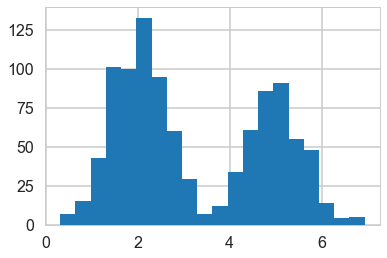

In [17]:
#In 1-D
# True parameter values
mu_true = [2, 5]
sigma_true = [0.6, 0.6]
lambda_true = .4
n = 1000

# Simulate from each distribution according to mixing proportion psi
z = np.random.binomial(1, lambda_true, n)
x = np.array([np.random.normal(mu_true[i], sigma_true[i]) for i in z])

plt.hist(x, bins=20);

In [18]:
#The 1000 z's we used in our simulation but which we shall promptly forget
z

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
#from Bios366 lecture notes
from scipy.stats.distributions import norm

def Estep(x, mu, sigma, lam):
    a = lam * norm.pdf(x, mu[0], sigma[0])
    b = (1. - lam) * norm.pdf(x, mu[1], sigma[1])
    return b / (a + b)



In [20]:
def Mstep(x, w):
    lam = np.mean(1.-w) 
    
    mu = [np.sum((1-w) * x)/np.sum(1-w), np.sum(w * x)/np.sum(w)]
    
    sigma = [np.sqrt(np.sum((1-w) * (x - mu[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mu[1])**2)/np.sum(w))]
    
    return mu, sigma, lam

In [21]:
print(lambda_true, mu_true, sigma_true)
# Initialize values
mu = np.random.normal(4, 10, size=2)
sigma = np.random.uniform(0, 5, size=2)
lam = np.random.random()
print("Initials, mu:", mu)
print("Initials, sigma:", sigma)
print("Initials, lam:", lam)

# Stopping criterion
crit = 1e-15

# Convergence flag
converged = False

# Loop until converged
iterations=1


while not converged:
    # E-step
    if np.isnan(mu[0]) or np.isnan(mu[1]) or np.isnan(sigma[0]) or np.isnan(sigma[1]):
        print("Singularity!")
        break
        
    w = Estep(x, mu, sigma, lam)

    # M-step
    mu_new, sigma_new, lam_new = Mstep(x, w)
    
    # Check convergence
    converged = ((np.abs(lam_new - lam) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    mu, sigma, lam = mu_new, sigma_new, lam_new
    iterations +=1           

print("Iterations", iterations)
print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\nlam: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], lam_new))

0.4 [2, 5] [0.6, 0.6]
Initials, mu: [-3.27370538 13.18149367]
Initials, sigma: [0.67264541 1.93315846]
Initials, lam: 0.3277268449314211
Iterations 62
A: N(2.0257, 0.5942)
B: N(5.0125, 0.6058)
lam: 0.5888


In [22]:
Estep(x, mu, sigma, lam)

array([9.99787856e-01, 2.45999765e-08, 9.99992371e-01, 1.08672116e-04,
       5.16395375e-08, 2.42485093e-07, 1.36761215e-02, 9.99999905e-01,
       1.05554767e-06, 4.61017423e-04, 6.84866370e-07, 3.50211327e-07,
       7.75852866e-07, 2.21922121e-07, 1.50610608e-04, 9.99999981e-01,
       9.98912460e-01, 4.36444493e-02, 3.49047627e-06, 9.99999770e-01,
       9.99999994e-01, 9.99999970e-01, 9.99991264e-01, 9.99991532e-01,
       9.99999995e-01, 2.21269155e-11, 3.46991788e-10, 1.25959348e-07,
       4.64883588e-01, 9.99999987e-01, 9.99997938e-01, 1.00000000e+00,
       1.32990437e-06, 9.99997819e-01, 9.99960035e-01, 1.00000000e+00,
       9.99999837e-01, 9.99967182e-01, 2.07285973e-06, 9.99998179e-01,
       9.99999506e-01, 9.91964431e-01, 3.34415726e-06, 6.77505973e-08,
       9.98312009e-01, 9.99992062e-01, 8.55310914e-07, 9.99999950e-01,
       9.99997991e-01, 4.69427519e-07, 7.70047999e-04, 9.99999998e-01,
       9.99999748e-01, 4.30985280e-05, 1.34354637e-04, 9.64900772e-01,
      

The output of the estep is indeed our classification probability, if we want to use our unsupervized model to make a classification.

In [23]:
zpred = 1*(Estep(x, mu, sigma, lam) >= 0.5)

In [24]:
zpred

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [25]:
np.mean(z==zpred)

0.994

## Survival Analysis using EM

The critical problem in survival analysis is that data tends to be right-censored. Imaginw a medical study following a cohort which has got cancer treatment. The study ends 5 years from start. Upto then, some patients have died. We record the time they died. But some were alive past the 5 years, and we stop recording, so we dont know, how long further from 5 years they will continue to live.

There are some key concepts and definitions we need.

Define T as a random lifetime taken from the population.

The **survival function** $S(t)$ of a population is defined as:

$$S(t) = P(T > t), $$

the probability of surviving past time t. The function $S$ is 1 minus the CDF of T, or $$S(t) = 1 - CDF_T(t)$$


The **Hazard Function** is defined as the probability that the death event occurs at time t, conditional on the fact that the death event has not occurred until time t. 

In other words, we care about:

$$\lambda(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{P( t \le T \le t + \delta t \mid T > t)}{\delta t}$$

Using Bayes Theorem we can see that:

$$\lambda(t) = \frac{-S'(t)}{S(t)}$$

Solving this differential equation needs:

$$S(t) = \exp\left( -\int_0^t \lambda(z) \mathrm{d}z \right)$$

For a constant Hazard Function, this is just an exponential model:

$$f_T(t) = \lambda(t)\exp\left( -\int_0^t \lambda(z) \mathrm{d}z \right)$$

(Formulae are taken from the docs for Python's lifelines package)

If you think we are being too morbid here, rest assured that survival analysis finds applications in many places, survival of politicians in office, survival os machinery and circuits. For example, a Weibull distribution which is concave is used to model all of early failures, random failures, and age related wear and tear, while the exponential distribution is used when u dont know how old the parts are (as then any memory based distribution is out). 

In general, you might even assume a non-parametric hazard and use techniques such as Kaplan-Meier estimation and Cox's proportional hazards (for regressions on subject covariates).

But let us focus on the exponential distribution.

As we said before, when our study ends, some patients are still alive. So we have incomplete data $z_m$ as the unseen lifetime for those censored, and the data we observe:

$$x_m = (a_m, d_m)$$

where $a_m$ is the age reached, and $d_m =1$ if the data was not censored and $d_m = 0$ if it was.

We assume that the age of death is exponentially distributed with constant hazard $\lambda$, so that

$$\ell(\{x_m\}, \{z_m\} \mid \lambda) = log \left( \prod_{m=1}^{n} \frac{1}{\lambda} e^{-\lambda x_m} \right)$$

Splitting the data up into censored and non-censored data, and expanding the log-likelihood we get:

$$\ell(\{x_m\}, \{z_m\} \mid \lambda) = -n log \lambda - \frac{1}{\lambda} \sum_{m=1}^{n} x_m = -n log \lambda - \frac{1}{\lambda} \sum_{m=1}^{n}  \left( a_m d_m + (1 - d_m) z_m \right)$$

Now the $Q$ function is the z-posterior expectation of the full-data likelihood, so that:

$$Q(\lambda, \lambda_{old}) = E_z \left[\ell(\{x_m\}, \{z_m\} \mid \lambda) \mid \lambda_{old} \right]$$

Thus we only need the expectations of the $z$ with respect to their posterior. Since we assume exponential distribution, we are assuming that our data is "memoryless". That is, given that we have survived till censoring, or expected survival time beyond that is simply $\lambda_{old}$, giving a total expected age equal to censoring-time plus $\lambda_{old}$.

Thus:

$$Q(\lambda, \lambda_{old}) = -n log \lambda - \frac{1}{\lambda}  \sum_{m=1}^{n} \left( a_m d_m + (1 - d_m) (c_m + \lambda_{old}) \right)$$

That does the e-step. The m-step simply differentiates this with respect to lambda to find the x-data MLE.

$$\lambda_{MLE} = \frac{1}{n} \left[\sum_{m=1}^{n} \left( a_m d_m + (1 - d_m) (c_m + \lambda_{old}) \right) \right]$$

In [31]:
def iteration(lamo, data):
    n = data.shape[0]
    summer = np.sum(data.a*data.d + (1-data.d)*(data.c + lamo))
    return summer/n
def run_em(data, lam_init, n_iter):
    lamo = lam_init
    for i in range(n_iter):
        lam_mle = iteration(lamo, data)
        lamo = lam_mle
        print("iteration i", i, lamo)

Hers is the data description:

```
Head and neck cancer from the Northeren California Oncology Group (NCOG)
Data matrix gives detailed time information, with t (months till death/censoring) being used in our analysis.
The column d is the death(1)/censoring(0) indicator, and arm the treatment arm (A Chemotherapy, B Chemotherapy + Radiation)
```

In [21]:
sdata = pd.read_csv("data/ncog.txt", sep=" ")
sdata.head()

,day,month,year,t,d,arm
0,19,6,78,248,1,A
1,15,12,78,160,1,A
2,20,7,78,319,0,A
3,17,11,78,277,1,A
4,15,12,78,440,1,A


In [22]:
sdata[sdata.d==0]

,day,month,year,t,d,arm
2,20,7,78,319,0,A
21,6,11,80,1226,0,A
24,22,1,81,74,0,A
27,12,6,81,1116,0,A
28,6,8,81,1412,0,A
30,15,7,81,1349,0,A
31,23,10,81,185,0,A
46,23,11,83,523,0,A
50,6,7,84,279,0,A
54,4,12,78,2146,0,B


In [25]:
sdata['a'] = sdata['c'] = sdata.t

In [26]:
sdata.head()

,day,month,year,t,d,arm,a,c
0,19,6,78,248,1,A,248,248
1,15,12,78,160,1,A,160,160
2,20,7,78,319,0,A,319,319
3,17,11,78,277,1,A,277,277
4,15,12,78,440,1,A,440,440


In [27]:
A_avg = np.mean(sdata[sdata.arm=='A'].t)
B_avg = np.mean(sdata[sdata.arm=='B'].t)
A_avg, B_avg

(357.84313725490193, 639.2)

In [32]:
run_em(sdata[sdata.arm=='A'], A_avg, 10)

iteration i 0 420.991926182
iteration i 1 432.135830111
iteration i 2 434.102401392
iteration i 3 434.449443383
iteration i 4 434.510686087
iteration i 5 434.521493623
iteration i 6 434.523400835
iteration i 7 434.523737402
iteration i 8 434.523796796
iteration i 9 434.523807278


In [34]:
run_em(sdata[sdata.arm=='B'], B_avg, 15)

iteration i 0 838.062222222
iteration i 1 899.930469136
iteration i 2 919.178368176
iteration i 3 925.166603432
iteration i 4 927.029609957
iteration i 5 927.609211987
iteration i 6 927.789532618
iteration i 7 927.84563237
iteration i 8 927.863085626
iteration i 9 927.868515528
iteration i 10 927.870204831
iteration i 11 927.870730392
iteration i 12 927.8708939
iteration i 13 927.870944769
iteration i 14 927.870960595


## Other resons why is EM important.

We have motivated the EM algorithm using mixture models and missing data, but that is not its only place of use. 

Since MLE's can overfit, we often prefer to use MAP estimation. EM is a perfectly reasonable method for MAP estimation in mixture models; you just need to multiply in the prior.

Basically the EM algorithm has a similar setup to the data augmentation problem and can be used in any problem which has a similar structure. Suppose for example you have two parameters $\phi$ and $\gamma$ in a posterior estimation, with daya $y$. Say that we'd like to estimate the posterior $p(\phi  \vert  y)$. It may be relatively hard to estimate this, but suppose we can  work with $p(\phi  \vert  \gamma, y)$ and $p(\gamma  \vert  \phi, y)$. Then you can use the structure of the EM algorithm to estimate the marginal posterior of any one parameter. Start with:

$$log p(\phi  \vert  y) = log p(\gamma, \phi  \vert  y) - log p(\gamma  \vert  \phi, y)$$

Notice the similarity of this to the above expressions with $\phi$ as $x$, $y$ as $\theta$, and $\gamma$ as $z$. Thus the same derivations apply toany problem with this structure.

This structure can also be used in type-2 likelihood or emprical bayes estimation.